In [1]:
import pandas as pd
import numpy as np

import os
import gc 
import math

# Data Cleaning

In [2]:
def load_raw_data(filename):

  raw_data_by_gvkey_fyear = pd.read_csv(filename, index_col=['gvkey', 'fyear'])
  sorted_data_raw_data = raw_data_by_gvkey_fyear.sort_index()

  feature_columns = [col for col in sorted_data_raw_data.columns if col != 'IBankrupt']

  return sorted_data_raw_data[feature_columns], sorted_data_raw_data['IBankrupt']

In [4]:
raw_features, raw_labels = load_raw_data('/home/tonyzou/bankruptcy-survival-analysis/data/data_for_bankruptcy_prediction_no_lags_corrected.csv')

In [44]:
def calculate_te(company_data):
    # Change fyear index to columns
    fyears_value = company_data.index.get_level_values('fyear')

    # Calculate all bankrupted years in NumPy arrays
    bankrupted_years = company_data.loc[company_data > 0].index.get_level_values('fyear')
    bankrupted_years_np = bankrupted_years.values.flatten()

    # Calculate all missing years in NumPy arrays
    presented_years = fyears_value.values
    all_years = np.arange(start=np.min(presented_years), stop=(np.max(presented_years)+2))
    missing_years_np = np.setdiff1d(all_years, presented_years) - 1

    # For definition 1, we treat both bankrupted years and missing years as event years
    event_years = np.concatenate([bankrupted_years_np, missing_years_np])

    # Return T: Time to the earliest event year(union of bankrupted year and missing year)
    def calculate_t(x):
        dist = x - event_years
        dist = dist[dist <= 0] # Future only
        dist = np.abs(dist) # Take absolute distance
        return min(dist) + 1
        
    # Return T for Definition 1: T = nearest future bankruptcy year, if not present, then nearest future missing year
    # def calculate_t(x):
    #     dist = x - bankrupted_years_np
    #     dist = dist[dist <= 0] # Future only
    #     dist = np.abs(dist)
    #     if dist.size == 0:
    #         return presented_years.max() - x + 1
    #     return np.min(dist)
    
    # Return E: if there are any future bankrupted year, return 1, else return 0
    def calculate_e(x):
        dist = x - bankrupted_years_np
        dist = dist[dist <= 0]
        if dist.size == 0:
            return 0
        return 1

    # Company_data is Series object, change to DataFrame to add columns
    x = company_data.to_frame()
    x['T'] = fyears_value.map(calculate_t)
    x['E'] = fyears_value.map(calculate_e)
    x['missing_years'] = fyears_value.map(lambda x: missing_years_np)
    x['bankrupted_years'] = fyears_value.map(lambda x: bankrupted_years_np)

    # Rename columns
    x = x.set_axis(['IBankrupt', 'T', 'E', 'missing_years', 'bankrupted_years'], axis=1, copy=False)
    return x

In [45]:
y = raw_labels.copy()
y = y.groupby(level=0, group_keys=False).apply(calculate_te)

In [48]:
y.loc[1364]

,IBankrupt,T,E,missing_years,bankrupted_years
fyear,,,,,
1980,0,2,1,[1982],[1981]
1981,1,1,1,[1982],[1981]
1982,0,1,0,[1982],[1981]


In [5]:
def drop_unknown_horizon(raw_labels, horizon=3):
    
    
    # Calculate T, E columns for each company
    y = raw_labels.copy()
    y = y.groupby(level=0, group_keys=False).apply(calculate_te)

    # For definition 2: 
    # Mask for all rows where bankrupted
    bankrupted_filter = y['E'] == 1
    # Mask for all rows where has information within horizon
    greater_than_horizon_filter = y['T'] > horizon
    # Use OR operation for two masks
    mask = bankrupted_filter | greater_than_horizon_filter

    y = y[mask]

    # Add column for companies bankrupted within horizon
    y['HBankrupt'] = ((y['T'] <= (horizon + 1)) & bankrupted_filter).astype(int)

    # For definition 1:
    # greater_than_horizon_filter = y['T'] > horizon
    # mask = greater_than_horizon_filter

    return y

In [22]:
def calculate_time_to_bankrupt(company_data, horizon=3):
    # Get all years
    fyears_value = company_data.index.get_level_values('fyear')

    bankrupted_years = company_data.loc[company_data > 0].index.get_level_values('fyear')
    bankrupted_years_np = bankrupted_years.values.flatten() + 1

    presented_years = fyears_value.values
    all_years = np.arange(start=np.min(presented_years), stop=(np.max(presented_years)+2))
    missing_years_np = np.setdiff1d(all_years, presented_years)
    
    event_years = np.concatenate([bankrupted_years_np, missing_years_np])

    # Return T for Definition 2: T = min(nearest future bankruptcy year, nearest future missing year)
    def calculate_t(x):
        dist = x - event_years
        dist = dist[dist <= 0] # Future only
        dist = np.abs(dist)
        return np.min(dist)
    
    # Return T for Definition 1: T = nearest future bankruptcy year, if not present, then nearest future missing year
    # def calculate_t(x):
    #     dist = x - bankrupted_years_np
    #     dist = dist[dist <= 0] # Future only
    #     dist = np.abs(dist)
    #     if dist.size == 0:
    #         return presented_years.max() - x + 1
    #     return np.min(dist)
    
    # Return E: if there are any future bankrupted year, return 1, else return 0
    def calculate_e(x):
        dist = x - bankrupted_years_np
        dist = dist[dist <= 0]
        if dist.size == 0:
            return 0
        return 1
    
    x = company_data.to_frame()
    x['T'] = fyears_value.map(calculate_t)
    x['E'] = fyears_value.map(calculate_e)
    x = x.set_axis(['IBankrupt', 'T', 'E'], axis=1, copy=False)
    return x
  
y = raw_labels.copy()
y = y.groupby(level=0, group_keys=False).apply(lambda x: calculate_time_to_bankrupt(x))

In [38]:
# y.loc[1043]
bankrupted_filter = y['E']==1
less_than_horizon_filter = y['T'] > 3
mask = bankrupted_filter | less_than_horizon_filter
y[mask]

IBankrupt   T  E
gvkey  fyear                  
1004   1983           0  35  0
       1984           0  34  0
       1985           0  33  0
       1986           0  32  0
       1987           0  31  0
...                 ...  .. ..
315887 2014           0   4  0
316056 2013           0   5  0
       2014           0   4  0
317260 2014           0   4  0
317264 2014           0   4  0

[60146 rows x 3 columns]

# Logistic Regression Training

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [259]:
x_train, x_test, y_train, y_test = data[0]
x_train_values = x_train.values[:, :75]
y_train_values = y_train.values
x_test_values = x_test.values[:, :75]
y_test_values = y_test.values

clf = LogisticRegression(max_iter=10000, random_state=42)
clf.fit(x_train_values, y_train_values)

predicts = clf.predict(x_test_values)

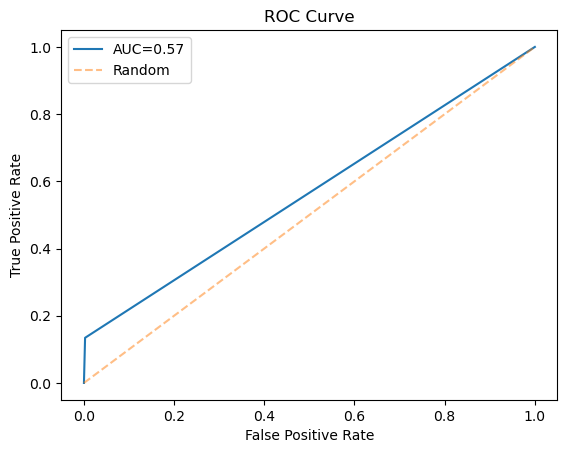

In [260]:
fpr, tpr, thresholds = roc_curve(y_test_values, predicts)
roc_auc = roc_auc_score(y_test_values, predicts)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()